In [1]:
## imports

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from ast import literal_eval

In [2]:
# other imports
from itscalledsoccer.client import AmericanSoccerAnalysis
asa_client = AmericanSoccerAnalysis()

Gathering all players
Gathering all teams
Gathering all stadia
Gathering all managers
Gathering all referees
Finished initializing client


### Getting the data from the API

In [3]:
stadia = asa_client.get_stadia(leagues='mls')
stadia.columns.to_list()

['stadium_id',
 'stadium_name',
 'capacity',
 'year_built',
 'roof',
 'turf',
 'street',
 'city',
 'province',
 'country',
 'postal_code',
 'latitude',
 'longitude',
 'field_x',
 'field_y',
 'competition']

In [4]:
refrees = asa_client.get_referees(leagues='mls')
refrees.columns.to_list()

['referee_id', 'referee_name', 'nationality', 'birth_date', 'competition']

In [5]:
managers = asa_client.get_managers(leagues='mls')
managers.columns.to_list()

['manager_id', 'manager_name', 'nationality', 'competition']

In [6]:
teams = asa_client.get_teams(leagues='mls')
teams.columns.to_list()

['team_id', 'team_name', 'team_short_name', 'team_abbreviation', 'competition']

In [7]:
players = asa_client.get_players(leagues='mls')
players.columns.to_list()

['player_id',
 'player_name',
 'birth_date',
 'nationality',
 'primary_broad_position',
 'primary_general_position',
 'secondary_broad_position',
 'secondary_general_position',
 'season_name',
 'height_ft',
 'height_in',
 'weight_lb',
 'competition']

In [8]:
games = asa_client.get_games(leagues='mls')
games.columns.to_list()

['game_id',
 'date_time_utc',
 'home_score',
 'away_score',
 'home_team_id',
 'away_team_id',
 'referee_id',
 'stadium_id',
 'home_manager_id',
 'away_manager_id',
 'expanded_minutes',
 'season_name',
 'matchday',
 'attendance',
 'knockout_game',
 'last_updated_utc',
 'extra_time',
 'penalties',
 'home_penalties',
 'away_penalties']

### Functions to filter the data

In [9]:
def filter_metric(players_df, games_df, client=asa_client, method='get_player_xgoals', start_season=2020, end_season=2023):
    '''
    returns df of player specific metric in the given season start to end ranges
    returned df contains the metric and the season_name column
    '''
    desired_range = [str(yr) for yr in list(range(start_season, end_season+1))]
    players_df = players_df[players_df['season_name'].apply(lambda seasons: set(seasons).issuperset(set(desired_range)))]    
    
    # getting the specific metric
    player_id_list = list(players_df.player_id.unique())
    
    dfs = []
    
    # get the method based on the client and the method name specified as arguments
    if hasattr(client, method):
        func = getattr(client, method)
    
    # columns to keep based on provided method
    
    if method == 'get_player_xgoals':
        columns_to_keep = ['player_id', 'minutes_played','xgoals', 'xassists', 'season_name']
    if method == 'get_player_xpass':
        columns_to_keep = ['player_id', 'minutes_played', 'attempted_passes', 'xpass_completion_percentage','season_name']
    if method == 'get_player_goals_added' or method == 'get_goalkeeper_goals_added':
        columns_to_keep = ['player_id', 'minutes_played', 'data', 'season_name']   
    if method == 'get_goalkeeper_xgoals':
        columns_to_keep = ['player_id', 'minutes_played', 'xgoals_gk_faced', 'saves', 'goals_conceded','season_name']         
        
    # iterate to get the dfs per player id
    for player_id in tqdm(player_id_list):
        print(f"Getting the metrics for {player_id}") 
        df = func(leagues = 'mls', player_ids = player_id, season_name=desired_range, split_by_games = True)
        
        # filter to meet minimum play time
        df = df[df['minutes_played']>=30]
        
        # add season name to the df
        df = pd.merge(df, games_df, on='game_id', how='left')
        
        # keep only wanted columns
        df = df[columns_to_keep].sort_values(by='season_name')
        
        # if the columns to keeo has a data columns of dictionaries then do the following
        if 'data' in columns_to_keep:
            print('reorganizing columns')
            reorganized_df_list = [] 
            for i,row in df.iterrows():
                df_ = pd.json_normalize(row['data'])[['action_type', 'goals_added_raw']].T
                df_.columns = df_.iloc[0]
                df_ = df_[1:]
                reorganized_df_list.append(df_)

            reorganized_df = pd.concat(reorganized_df_list, axis = 0).reset_index(drop = True)
            
            # concatenate the reorganized df with the orginal df, drop the data column
            df = pd.concat([df, reorganized_df], axis = 1).drop('data', axis=1)
            df['goals_added_total'] = df['Dribbling'] + df['Fouling'] + df['Interrupting'] + df['Passing'] + df['Receiving']+ df['Shooting']
            
        dfs.append(df)
    
    # concatenate and return result
    df_concat = pd.concat(dfs, ignore_index=True)
    
    # write to csv
    folder = 'data'
    df_name = str(f'{players_df}')
    if not os.path.exists(folder):
        os.mkdirs(folder)
    export_path = folder + '/' + f'filtered_players'+ '_'+ f'{method}' + '.csv'
    print(export_path)
    df_concat.to_csv(export_path, index = False)
    
    return df_concat

In [10]:
## Latent Metrics - Discrimination

def discrimination_season(df, metric='xgoals', season = 2020):
    ''' returns discrimination ability of the metric in the specified season''' 
    
    # Noise to avoid zero division error
    eta = 0.001
    
    # Filter rows with non-null values in the specified column
    data = df[['season_name', 'player_id', metric]].dropna(subset=[metric])
    # Filter rows based on the specified season
    data = data[data['season_name'] == season]
    
    # Count the number of data points for each player
    # player_data_counts = data.groupby('player_id').size()

    # Filter out player_ids with less than two data points for the metric
    # valid_player_ids = player_data_counts[player_data_counts >= 2].index
    # data = data[data['player_id'].isin(valid_player_ids)]
    
    # Calculate sample intra_variance and sample cross_variance
    data['cross_variance'] = data[metric].var(ddof=0)
    result_data = data.groupby('player_id').agg(
        intra_variance=pd.NamedAgg(column=metric, aggfunc=lambda x: x.var(ddof=0)),
        cross_variance=pd.NamedAgg(column='cross_variance', aggfunc='mean')
    )
    
    # Calculate and return the discrimination score
    return 1 - ((result_data['intra_variance'].mean()+eta) / (result_data['cross_variance'].mean()+eta))

In [11]:
# Latent metrics - Stability

def stability_scores(df, metric='xgoals'):
    '''
    returns the stability metric 
    '''
    # noise to avoid zero division error
    eta = 0.001
    
    btw_season_variance = df.groupby('player_id').agg(
       bs_variance=pd.NamedAgg(column=metric, aggfunc=lambda x: x.var(ddof=0))
    )['bs_variance'].mean()
    
    within_season_player_variance = df.groupby(['player_id', 'season_name']).agg(
        wsp_variance=pd.NamedAgg(column=metric, aggfunc=lambda x: x.var(ddof=0))
    )['wsp_variance'].mean()
    
    overall_variance = df[metric].var(ddof=0)
    
    stability = 1 - (((btw_season_variance - within_season_player_variance)+eta) / ((overall_variance - within_season_player_variance)+eta))
    
    return stability

## Filtering out the players of interest

In [12]:
# midfielders, primary position
players_midfield = players[players['primary_broad_position']== 'MF']

In [13]:
# select the midfielders who played in sesons 2020 to 2023
start_season = 2018
end_season = 2023
desired_range = [str(yr) for yr in list(range(start_season, end_season+1))]

players_midfield = players_midfield[players_midfield['season_name'].apply(lambda seasons: set(seasons).issuperset(set(desired_range)))]

In [14]:
# Number of players to assess
players_midfield.shape

(57, 13)

In [15]:
players_midfield[['player_id', 'player_name']].reset_index(drop=True)

,player_id,player_name
0,0Oq6lyNdM6,Wil Trapp
1,0Oq6wv26Q6,Jonathan Lewis
2,0x5gXlrq7O,Roger Espinoza
3,2lqRRvNxqr,Scott Caldwell
4,2lqRRZy2qr,Ilie Sánchez
5,2vQ1LYxbqr,Paul Arriola
6,2vQ1LYY0qr,Emmanuel Boateng
7,4JMAaaxkMK,Sebastian Lletget
8,4wM42Belqj,Mark Delgado
9,7vQ73NxYQD,Kelyn Rowe


## Extracting the dataframe for the filtered players and range of seasons by API calls

In [16]:
xpasspercent = filter_metric(players_midfield, games, asa_client, 'get_player_xpass', start_season, end_season)

  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

Getting the metrics for 0Oq6lyNdM6


  2%|█▍                                                                                 | 1/57 [00:01<01:17,  1.39s/it]

Getting the metrics for 0Oq6wv26Q6


  4%|██▉                                                                                | 2/57 [00:02<01:07,  1.22s/it]

Getting the metrics for 0x5gXlrq7O


  5%|████▎                                                                              | 3/57 [00:04<01:14,  1.39s/it]

Getting the metrics for 2lqRRvNxqr


  7%|█████▊                                                                             | 4/57 [00:05<01:18,  1.48s/it]

Getting the metrics for 2lqRRZy2qr


  9%|███████▎                                                                           | 5/57 [00:06<01:12,  1.40s/it]

Getting the metrics for 2vQ1LYxbqr


 11%|████████▋                                                                          | 6/57 [00:08<01:06,  1.31s/it]

Getting the metrics for 2vQ1LYY0qr


 12%|██████████▏                                                                        | 7/57 [00:09<01:03,  1.28s/it]

Getting the metrics for 4JMAaaxkMK


 14%|███████████▋                                                                       | 8/57 [00:10<01:08,  1.39s/it]

Getting the metrics for 4wM42Belqj


 16%|█████████████                                                                      | 9/57 [00:12<01:11,  1.48s/it]

Getting the metrics for 7vQ73NxYQD


 18%|██████████████▍                                                                   | 10/57 [00:14<01:17,  1.65s/it]

Getting the metrics for 7vQ7rPpOqD


 19%|███████████████▊                                                                  | 11/57 [00:15<01:11,  1.55s/it]

Getting the metrics for 7VqGj3RA5v


 21%|█████████████████▎                                                                | 12/57 [00:17<01:04,  1.43s/it]

Getting the metrics for 9vQ22OOoQK


 23%|██████████████████▋                                                               | 13/57 [00:18<01:00,  1.38s/it]

Getting the metrics for 9vQ2d3X75K


 25%|████████████████████▏                                                             | 14/57 [00:19<00:56,  1.32s/it]

Getting the metrics for 9vQ2dAKY5K


 26%|█████████████████████▌                                                            | 15/57 [00:21<01:00,  1.44s/it]

Getting the metrics for a35rlyZ4QL


 28%|███████████████████████                                                           | 16/57 [00:22<00:55,  1.36s/it]

Getting the metrics for aDQ0PjnGQE


 30%|████████████████████████▍                                                         | 17/57 [00:23<00:52,  1.31s/it]

Getting the metrics for BLMv1GlQxe


 32%|█████████████████████████▉                                                        | 18/57 [00:25<00:57,  1.47s/it]

Getting the metrics for BLMvlPy3qx


 33%|███████████████████████████▎                                                      | 19/57 [00:27<00:56,  1.50s/it]

Getting the metrics for e7Mz9DgGQr


 35%|████████████████████████████▊                                                     | 20/57 [00:29<01:10,  1.91s/it]

Getting the metrics for eV5D9A9qKn


 37%|██████████████████████████████▏                                                   | 21/57 [00:33<01:23,  2.32s/it]

Getting the metrics for eV5DLedE5K


 39%|███████████████████████████████▋                                                  | 22/57 [00:37<01:43,  2.95s/it]

Getting the metrics for eVq3a8XyMW


 40%|█████████████████████████████████                                                 | 23/57 [00:41<01:46,  3.14s/it]

Getting the metrics for eVq3apWvMW


 42%|██████████████████████████████████▌                                               | 24/57 [00:42<01:30,  2.73s/it]

Getting the metrics for eVq3jYZv5W


 44%|███████████████████████████████████▉                                              | 25/57 [00:45<01:29,  2.79s/it]

Getting the metrics for eVq3xXDDQW


 46%|█████████████████████████████████████▍                                            | 26/57 [01:11<04:56,  9.58s/it]

Getting the metrics for gjMNv7PpMK


 47%|██████████████████████████████████████▊                                           | 27/57 [01:12<03:34,  7.15s/it]

Getting the metrics for gjMNvjYvMK


 49%|████████████████████████████████████████▎                                         | 28/57 [01:14<02:37,  5.44s/it]

Getting the metrics for gOMn66nAMw


 51%|█████████████████████████████████████████▋                                        | 29/57 [01:16<02:02,  4.37s/it]

Getting the metrics for gOMnR96lMw


 53%|███████████████████████████████████████████▏                                      | 30/57 [01:18<01:42,  3.78s/it]

Getting the metrics for gOMnRPxXMw


 54%|████████████████████████████████████████████▌                                     | 31/57 [01:19<01:19,  3.05s/it]

Getting the metrics for gpMOa6zrqz


 56%|██████████████████████████████████████████████                                    | 32/57 [01:21<01:03,  2.56s/it]

Getting the metrics for gpMOyGlqzy


 58%|███████████████████████████████████████████████▍                                  | 33/57 [01:22<00:49,  2.08s/it]

Getting the metrics for jYQJOaZMGR


 60%|████████████████████████████████████████████████▉                                 | 34/57 [01:23<00:40,  1.77s/it]

Getting the metrics for KAqBjWZBqb


 61%|██████████████████████████████████████████████████▎                               | 35/57 [01:25<00:39,  1.81s/it]

Getting the metrics for KPqj7jY4Q6


 63%|███████████████████████████████████████████████████▊                              | 36/57 [01:26<00:37,  1.76s/it]

Getting the metrics for KPqj7OVPQ6


 65%|█████████████████████████████████████████████████████▏                            | 37/57 [01:28<00:32,  1.61s/it]

Getting the metrics for KPqjodRYQ6


 67%|██████████████████████████████████████████████████████▋                           | 38/57 [01:29<00:28,  1.48s/it]

Getting the metrics for KPqjodW4Q6


 68%|████████████████████████████████████████████████████████                          | 39/57 [01:30<00:25,  1.40s/it]

Getting the metrics for KPqjzJ2q6v


 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [01:32<00:24,  1.47s/it]

Getting the metrics for kRQa207YMK


 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [01:33<00:21,  1.37s/it]

Getting the metrics for KXMe4l1Q64


 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [01:35<00:22,  1.52s/it]

Getting the metrics for KXMeAPkM64


 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [01:37<00:23,  1.65s/it]

Getting the metrics for ljqE2EWkQx


 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [01:38<00:19,  1.51s/it]

Getting the metrics for ljqE2PwVQx


 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [01:39<00:17,  1.45s/it]

Getting the metrics for ljqEjLaEQx


 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [01:41<00:16,  1.51s/it]

Getting the metrics for NWMWeDYqlz


 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [01:42<00:14,  1.46s/it]

Getting the metrics for Oa5wVgVYM1


 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [01:43<00:12,  1.39s/it]

Getting the metrics for p6qbenoB50


 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [01:45<00:12,  1.54s/it]

Getting the metrics for raMyAGEBMd


 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [01:47<00:11,  1.58s/it]

Getting the metrics for raMyAZR2Md


 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [01:48<00:08,  1.45s/it]

Getting the metrics for Vj58YwDDq8


 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [01:50<00:07,  1.56s/it]

Getting the metrics for Vj58zZ2Q8n


 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [01:52<00:06,  1.59s/it]

Getting the metrics for wvq9bOBQWn


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [01:53<00:04,  1.62s/it]

Getting the metrics for wvq9pBZm5W


 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [01:55<00:03,  1.61s/it]

Getting the metrics for xW5prbllQg


 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [01:56<00:01,  1.62s/it]

Getting the metrics for zeQZJX6KQK


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [01:58<00:00,  2.07s/it]

data/filtered_players_get_player_xpass.csv


In [17]:
goals_added = filter_metric(players_midfield, games, asa_client, 'get_player_goals_added', start_season, end_season)

  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

Getting the metrics for 0Oq6lyNdM6


  2%|█▍                                                                                 | 1/57 [00:02<02:00,  2.15s/it]

reorganizing columns
Getting the metrics for 0Oq6wv26Q6


  4%|██▉                                                                                | 2/57 [00:03<01:41,  1.85s/it]

reorganizing columns
Getting the metrics for 0x5gXlrq7O


  5%|████▎                                                                              | 3/57 [00:05<01:39,  1.85s/it]

reorganizing columns
Getting the metrics for 2lqRRvNxqr


  7%|█████▊                                                                             | 4/57 [00:07<01:28,  1.67s/it]

reorganizing columns
Getting the metrics for 2lqRRZy2qr


  9%|███████▎                                                                           | 5/57 [00:09<01:37,  1.88s/it]

reorganizing columns
Getting the metrics for 2vQ1LYxbqr


 11%|████████▋                                                                          | 6/57 [00:11<01:33,  1.83s/it]

reorganizing columns
Getting the metrics for 2vQ1LYY0qr


 12%|██████████▏                                                                        | 7/57 [00:12<01:23,  1.67s/it]

reorganizing columns
Getting the metrics for 4JMAaaxkMK


 14%|███████████▋                                                                       | 8/57 [00:14<01:21,  1.66s/it]

reorganizing columns
Getting the metrics for 4wM42Belqj


 16%|█████████████                                                                      | 9/57 [00:15<01:19,  1.67s/it]

reorganizing columns
Getting the metrics for 7vQ73NxYQD


 18%|██████████████▍                                                                   | 10/57 [00:17<01:19,  1.68s/it]

reorganizing columns
Getting the metrics for 7vQ7rPpOqD


 19%|███████████████▊                                                                  | 11/57 [00:19<01:20,  1.76s/it]

reorganizing columns
Getting the metrics for 7VqGj3RA5v


 21%|█████████████████▎                                                                | 12/57 [00:21<01:18,  1.75s/it]

reorganizing columns
Getting the metrics for 9vQ22OOoQK


 23%|██████████████████▋                                                               | 13/57 [00:22<01:19,  1.80s/it]

reorganizing columns
Getting the metrics for 9vQ2d3X75K


 25%|████████████████████▏                                                             | 14/57 [00:24<01:15,  1.77s/it]

reorganizing columns
Getting the metrics for 9vQ2dAKY5K


 26%|█████████████████████▌                                                            | 15/57 [00:26<01:15,  1.80s/it]

reorganizing columns
Getting the metrics for a35rlyZ4QL


 28%|███████████████████████                                                           | 16/57 [00:28<01:19,  1.93s/it]

reorganizing columns
Getting the metrics for aDQ0PjnGQE


 30%|████████████████████████▍                                                         | 17/57 [00:30<01:13,  1.85s/it]

reorganizing columns
Getting the metrics for BLMv1GlQxe
reorganizing columns


 32%|█████████████████████████▉                                                        | 18/57 [00:32<01:12,  1.85s/it]

Getting the metrics for BLMvlPy3qx


 33%|███████████████████████████▎                                                      | 19/57 [00:36<01:35,  2.51s/it]

reorganizing columns
Getting the metrics for e7Mz9DgGQr


 35%|████████████████████████████▊                                                     | 20/57 [00:39<01:37,  2.65s/it]

reorganizing columns
Getting the metrics for eV5D9A9qKn


 37%|██████████████████████████████▏                                                   | 21/57 [00:42<01:43,  2.88s/it]

reorganizing columns
Getting the metrics for eV5DLedE5K


 39%|███████████████████████████████▋                                                  | 22/57 [00:45<01:44,  2.99s/it]

reorganizing columns
Getting the metrics for eVq3a8XyMW


 40%|█████████████████████████████████                                                 | 23/57 [00:48<01:37,  2.88s/it]

reorganizing columns
Getting the metrics for eVq3apWvMW
reorganizing columns


 42%|██████████████████████████████████▌                                               | 24/57 [00:52<01:43,  3.13s/it]

Getting the metrics for eVq3jYZv5W


 44%|███████████████████████████████████▉                                              | 25/57 [00:54<01:27,  2.75s/it]

reorganizing columns
Getting the metrics for eVq3xXDDQW


 46%|█████████████████████████████████████▍                                            | 26/57 [00:57<01:29,  2.90s/it]

reorganizing columns
Getting the metrics for gjMNv7PpMK


 47%|██████████████████████████████████████▊                                           | 27/57 [01:00<01:27,  2.92s/it]

reorganizing columns
Getting the metrics for gjMNvjYvMK


 49%|████████████████████████████████████████▎                                         | 28/57 [01:03<01:28,  3.04s/it]

reorganizing columns
Getting the metrics for gOMn66nAMw


 51%|█████████████████████████████████████████▋                                        | 29/57 [01:07<01:28,  3.16s/it]

reorganizing columns
Getting the metrics for gOMnR96lMw
reorganizing columns


 53%|███████████████████████████████████████████▏                                      | 30/57 [01:10<01:27,  3.23s/it]

Getting the metrics for gOMnRPxXMw


 54%|████████████████████████████████████████████▌                                     | 31/57 [01:14<01:28,  3.42s/it]

reorganizing columns
Getting the metrics for gpMOa6zrqz


 56%|██████████████████████████████████████████████                                    | 32/57 [01:17<01:24,  3.36s/it]

reorganizing columns
Getting the metrics for gpMOyGlqzy


 58%|███████████████████████████████████████████████▍                                  | 33/57 [01:19<01:08,  2.86s/it]

reorganizing columns
Getting the metrics for jYQJOaZMGR


 60%|████████████████████████████████████████████████▉                                 | 34/57 [01:21<00:58,  2.53s/it]

reorganizing columns
Getting the metrics for KAqBjWZBqb


 61%|██████████████████████████████████████████████████▎                               | 35/57 [01:23<00:54,  2.48s/it]

reorganizing columns
Getting the metrics for KPqj7jY4Q6


 63%|███████████████████████████████████████████████████▊                              | 36/57 [01:25<00:50,  2.40s/it]

reorganizing columns
Getting the metrics for KPqj7OVPQ6


 65%|█████████████████████████████████████████████████████▏                            | 37/57 [01:27<00:41,  2.10s/it]

reorganizing columns
Getting the metrics for KPqjodRYQ6
reorganizing columns


 67%|██████████████████████████████████████████████████████▋                           | 38/57 [01:28<00:38,  2.02s/it]

Getting the metrics for KPqjodW4Q6


 68%|████████████████████████████████████████████████████████                          | 39/57 [01:30<00:35,  1.97s/it]

reorganizing columns
Getting the metrics for KPqjzJ2q6v


 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [01:32<00:31,  1.88s/it]

reorganizing columns
Getting the metrics for kRQa207YMK


 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [01:33<00:28,  1.77s/it]

reorganizing columns
Getting the metrics for KXMe4l1Q64


 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [01:36<00:30,  2.04s/it]

reorganizing columns
Getting the metrics for KXMeAPkM64
reorganizing columns


 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [01:38<00:29,  2.11s/it]

Getting the metrics for ljqE2EWkQx
reorganizing columns


 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [01:40<00:26,  2.04s/it]

Getting the metrics for ljqE2PwVQx
reorganizing columns


 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [01:42<00:23,  1.96s/it]

Getting the metrics for ljqEjLaEQx
reorganizing columns


 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [01:44<00:21,  1.94s/it]

Getting the metrics for NWMWeDYqlz


 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [01:46<00:20,  2.00s/it]

reorganizing columns
Getting the metrics for Oa5wVgVYM1


 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [01:48<00:18,  2.03s/it]

reorganizing columns
Getting the metrics for p6qbenoB50


 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [01:50<00:15,  1.98s/it]

reorganizing columns
Getting the metrics for raMyAGEBMd


 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [01:52<00:13,  1.98s/it]

reorganizing columns
Getting the metrics for raMyAZR2Md
reorganizing columns


 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [01:54<00:11,  1.90s/it]

Getting the metrics for Vj58YwDDq8


 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [01:55<00:09,  1.83s/it]

reorganizing columns
Getting the metrics for Vj58zZ2Q8n


 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [01:57<00:07,  1.78s/it]

reorganizing columns
Getting the metrics for wvq9bOBQWn


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [01:59<00:05,  1.96s/it]

reorganizing columns
Getting the metrics for wvq9pBZm5W


 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [02:01<00:03,  1.74s/it]

reorganizing columns
Getting the metrics for xW5prbllQg


 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [02:02<00:01,  1.70s/it]

reorganizing columns
Getting the metrics for zeQZJX6KQK


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [02:05<00:00,  2.20s/it]

reorganizing columns
data/filtered_players_get_player_goals_added.csv


In [18]:
xgoals = filter_metric(players_midfield, games, asa_client, 'get_player_xgoals', start_season, end_season)

  0%|                                                                                           | 0/57 [00:00<?, ?it/s]

Getting the metrics for 0Oq6lyNdM6


  2%|█▍                                                                                 | 1/57 [00:01<01:05,  1.17s/it]

Getting the metrics for 0Oq6wv26Q6


  4%|██▉                                                                                | 2/57 [00:02<01:01,  1.12s/it]

Getting the metrics for 0x5gXlrq7O


  5%|████▎                                                                              | 3/57 [00:03<01:13,  1.36s/it]

Getting the metrics for 2lqRRvNxqr


  7%|█████▊                                                                             | 4/57 [00:05<01:15,  1.43s/it]

Getting the metrics for 2lqRRZy2qr


  9%|███████▎                                                                           | 5/57 [00:06<01:08,  1.31s/it]

Getting the metrics for 2vQ1LYxbqr


 11%|████████▋                                                                          | 6/57 [00:08<01:12,  1.42s/it]

Getting the metrics for 2vQ1LYY0qr


 12%|██████████▏                                                                        | 7/57 [00:09<01:08,  1.37s/it]

Getting the metrics for 4JMAaaxkMK


 14%|███████████▋                                                                       | 8/57 [00:10<01:02,  1.27s/it]

Getting the metrics for 4wM42Belqj


 16%|█████████████                                                                      | 9/57 [00:11<00:58,  1.22s/it]

Getting the metrics for 7vQ73NxYQD


 18%|██████████████▍                                                                   | 10/57 [00:12<00:56,  1.20s/it]

Getting the metrics for 7vQ7rPpOqD


 19%|███████████████▊                                                                  | 11/57 [00:13<00:52,  1.15s/it]

Getting the metrics for 7VqGj3RA5v


 21%|█████████████████▎                                                                | 12/57 [00:14<00:50,  1.13s/it]

Getting the metrics for 9vQ22OOoQK


 23%|██████████████████▋                                                               | 13/57 [00:16<00:57,  1.31s/it]

Getting the metrics for 9vQ2d3X75K


 25%|████████████████████▏                                                             | 14/57 [00:17<00:55,  1.30s/it]

Getting the metrics for 9vQ2dAKY5K


 26%|█████████████████████▌                                                            | 15/57 [00:19<01:02,  1.49s/it]

Getting the metrics for a35rlyZ4QL


 28%|███████████████████████                                                           | 16/57 [00:21<01:02,  1.53s/it]

Getting the metrics for aDQ0PjnGQE


 30%|████████████████████████▍                                                         | 17/57 [00:23<01:02,  1.57s/it]

Getting the metrics for BLMv1GlQxe


 32%|█████████████████████████▉                                                        | 18/57 [00:24<00:58,  1.49s/it]

Getting the metrics for BLMvlPy3qx


 33%|███████████████████████████▎                                                      | 19/57 [00:25<00:52,  1.37s/it]

Getting the metrics for e7Mz9DgGQr


 35%|████████████████████████████▊                                                     | 20/57 [00:27<00:53,  1.44s/it]

Getting the metrics for eV5D9A9qKn


 37%|██████████████████████████████▏                                                   | 21/57 [00:28<00:48,  1.36s/it]

Getting the metrics for eV5DLedE5K


 39%|███████████████████████████████▋                                                  | 22/57 [00:29<00:47,  1.36s/it]

Getting the metrics for eVq3a8XyMW


 40%|█████████████████████████████████                                                 | 23/57 [00:30<00:45,  1.35s/it]

Getting the metrics for eVq3apWvMW


 42%|██████████████████████████████████▌                                               | 24/57 [00:32<00:43,  1.33s/it]

Getting the metrics for eVq3jYZv5W


 44%|███████████████████████████████████▉                                              | 25/57 [00:33<00:45,  1.41s/it]

Getting the metrics for eVq3xXDDQW


 46%|█████████████████████████████████████▍                                            | 26/57 [00:35<00:45,  1.47s/it]

Getting the metrics for gjMNv7PpMK


 47%|██████████████████████████████████████▊                                           | 27/57 [00:37<00:46,  1.55s/it]

Getting the metrics for gjMNvjYvMK


 49%|████████████████████████████████████████▎                                         | 28/57 [00:38<00:45,  1.56s/it]

Getting the metrics for gOMn66nAMw


 51%|█████████████████████████████████████████▋                                        | 29/57 [00:40<00:43,  1.55s/it]

Getting the metrics for gOMnR96lMw


 53%|███████████████████████████████████████████▏                                      | 30/57 [00:42<00:44,  1.66s/it]

Getting the metrics for gOMnRPxXMw


 54%|████████████████████████████████████████████▌                                     | 31/57 [00:43<00:37,  1.42s/it]

Getting the metrics for gpMOa6zrqz


 56%|██████████████████████████████████████████████                                    | 32/57 [00:44<00:35,  1.42s/it]

Getting the metrics for gpMOyGlqzy


 58%|███████████████████████████████████████████████▍                                  | 33/57 [00:45<00:29,  1.24s/it]

Getting the metrics for jYQJOaZMGR


 60%|████████████████████████████████████████████████▉                                 | 34/57 [00:46<00:30,  1.31s/it]

Getting the metrics for KAqBjWZBqb


 61%|██████████████████████████████████████████████████▎                               | 35/57 [00:47<00:27,  1.25s/it]

Getting the metrics for KPqj7jY4Q6


 63%|███████████████████████████████████████████████████▊                              | 36/57 [00:48<00:25,  1.21s/it]

Getting the metrics for KPqj7OVPQ6


 65%|█████████████████████████████████████████████████████▏                            | 37/57 [00:50<00:26,  1.31s/it]

Getting the metrics for KPqjodRYQ6


 67%|██████████████████████████████████████████████████████▋                           | 38/57 [00:52<00:25,  1.36s/it]

Getting the metrics for KPqjodW4Q6


 68%|████████████████████████████████████████████████████████                          | 39/57 [00:53<00:24,  1.36s/it]

Getting the metrics for KPqjzJ2q6v


 70%|█████████████████████████████████████████████████████████▌                        | 40/57 [00:54<00:23,  1.35s/it]

Getting the metrics for kRQa207YMK


 72%|██████████████████████████████████████████████████████████▉                       | 41/57 [00:56<00:23,  1.45s/it]

Getting the metrics for KXMe4l1Q64


 74%|████████████████████████████████████████████████████████████▍                     | 42/57 [00:57<00:20,  1.38s/it]

Getting the metrics for KXMeAPkM64


 75%|█████████████████████████████████████████████████████████████▊                    | 43/57 [00:59<00:20,  1.45s/it]

Getting the metrics for ljqE2EWkQx


 77%|███████████████████████████████████████████████████████████████▎                  | 44/57 [01:00<00:18,  1.44s/it]

Getting the metrics for ljqE2PwVQx


 79%|████████████████████████████████████████████████████████████████▋                 | 45/57 [01:02<00:17,  1.49s/it]

Getting the metrics for ljqEjLaEQx


 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [01:03<00:15,  1.43s/it]

Getting the metrics for NWMWeDYqlz


 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [01:05<00:14,  1.48s/it]

Getting the metrics for Oa5wVgVYM1


 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [01:06<00:12,  1.42s/it]

Getting the metrics for p6qbenoB50


 86%|██████████████████████████████████████████████████████████████████████▍           | 49/57 [01:07<00:11,  1.40s/it]

Getting the metrics for raMyAGEBMd


 88%|███████████████████████████████████████████████████████████████████████▉          | 50/57 [01:09<00:09,  1.40s/it]

Getting the metrics for raMyAZR2Md


 89%|█████████████████████████████████████████████████████████████████████████▎        | 51/57 [01:10<00:09,  1.53s/it]

Getting the metrics for Vj58YwDDq8


 91%|██████████████████████████████████████████████████████████████████████████▊       | 52/57 [01:12<00:07,  1.45s/it]

Getting the metrics for Vj58zZ2Q8n


 93%|████████████████████████████████████████████████████████████████████████████▏     | 53/57 [01:14<00:06,  1.57s/it]

Getting the metrics for wvq9bOBQWn


 95%|█████████████████████████████████████████████████████████████████████████████▋    | 54/57 [01:16<00:05,  1.69s/it]

Getting the metrics for wvq9pBZm5W


 96%|███████████████████████████████████████████████████████████████████████████████   | 55/57 [01:17<00:03,  1.59s/it]

Getting the metrics for xW5prbllQg


 98%|████████████████████████████████████████████████████████████████████████████████▌ | 56/57 [01:18<00:01,  1.45s/it]

Getting the metrics for zeQZJX6KQK


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [01:19<00:00,  1.40s/it]

data/filtered_players_get_player_xgoals.csv


### Combine the dataframes into one datafra

In [19]:
selected_columns = list(set(list(xpasspercent.columns) + list(xgoals.columns) + list(goals_added)))

In [20]:
result_df = pd.concat([xpasspercent, goals_added, xgoals], axis=1)


In [21]:
result_df = result_df[selected_columns]

In [22]:
# drop duplicated columns

result_df = result_df.loc[:, ~result_df.columns.duplicated()]

In [23]:
# adding the player_name colum to the result
# Merge dataframes on 'player_id'

result_df = pd.merge(result_df, players[['player_id', 'player_name']], on='player_id', how='left')

In [24]:
reordered_cols = ['player_id','player_name', 'minutes_played'] + [col for col in list(result_df.columns) if col not in ['player_id','player_name', 'minutes_played']]

In [25]:
reordered_cols

['player_id',
 'player_name',
 'minutes_played',
 'Dribbling',
 'xpass_completion_percentage',
 'Passing',
 'attempted_passes',
 'Interrupting',
 'Shooting',
 'season_name',
 'Receiving',
 'goals_added_total',
 'xassists',
 'Fouling',
 'xgoals']

In [26]:
result_df = result_df[reordered_cols]

In [27]:
# Wrting to csv

result_df.to_csv('data/metrics_dataframe.csv', index = False)

### Read the data and compute meta metrics

In [28]:
df = pd.read_csv('data/metrics_dataframe.csv')

In [29]:
metrics= [col for col in list(df.columns) if col not in ['player_id', 'player_name', 'minutes_played', 'season_name']]

In [30]:
## Function to compute discrimination and stability of each metric 

In [31]:
final_columns = list(range(start_season, end_season+1))+['stability']

In [32]:
final_df = pd.DataFrame(index=metrics, columns=final_columns)

In [33]:
for metric in metrics:
    for column in final_columns:
        if column == 'stability':
            continue
        value = discrimination_season(df, metric, column)
        # store the computed discrimination in result
        final_df.at[metric, column]= value
    
    stability_score = stability_scores(df, metric)
    # store the stability score
    final_df.at[metric, 'stability'] = stability_score

In [34]:
final_df

,2018,2019,2020,2021,2022,2023,stability
Dribbling,0.056571,0.04929,0.097037,0.107148,0.126137,0.048372,0.041469
xpass_completion_percentage,0.476738,0.438946,0.434802,0.427516,0.434307,0.475112,0.622099
Passing,0.210051,0.171898,0.190029,0.182569,0.181517,0.204182,0.412388
attempted_passes,0.560163,0.534005,0.528459,0.547297,0.497899,0.536853,0.761813
Interrupting,0.181811,0.144564,0.104235,0.07629,0.117593,0.182544,0.306864
Shooting,0.138425,0.104813,0.129063,0.129145,0.107773,0.094482,0.138637
Receiving,0.217061,0.175127,0.196123,0.222976,0.200856,0.186194,0.382239
goals_added_total,0.19339,0.121212,0.17034,0.179859,0.162854,0.134239,0.425229
xassists,0.246389,0.247361,0.200596,0.167499,0.23577,0.217004,0.478103
Fouling,0.110523,0.084648,0.102197,0.034567,0.024858,0.14855,0.068005


In [35]:
## Write output
folder = 'results'
if not os.path.exists(folder):
    os.mkdir(folder)
export_path = folder + '/' + 'output' + '.csv'
final_df.to_csv(export_path, index = True)

### Heatmap

In [36]:
final_df  = final_df.apply(pd.to_numeric)

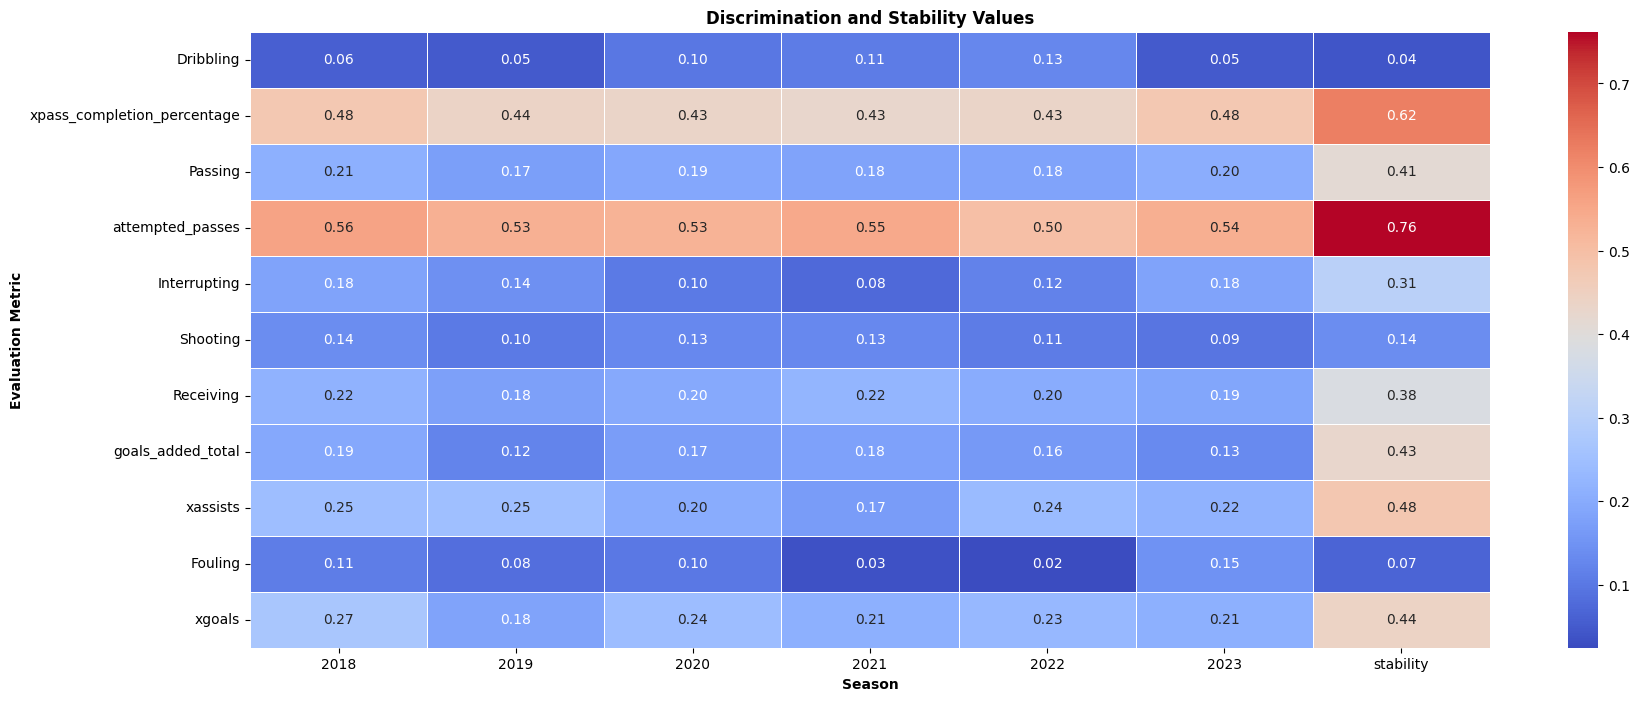

In [37]:
plt.figure(figsize=(20, 8))
sns.heatmap(final_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Discrimination and Stability Values', fontweight = 'bold')
plt.xlabel('Season', fontweight='bold')
plt.ylabel('Evaluation Metric', fontweight='bold')

## Write output
folder = 'results'
if not os.path.exists(folder):
    os.mkdir(folder)
export_path = folder + '/' + 'heatmap' + '.png'
plt.savefig(export_path)

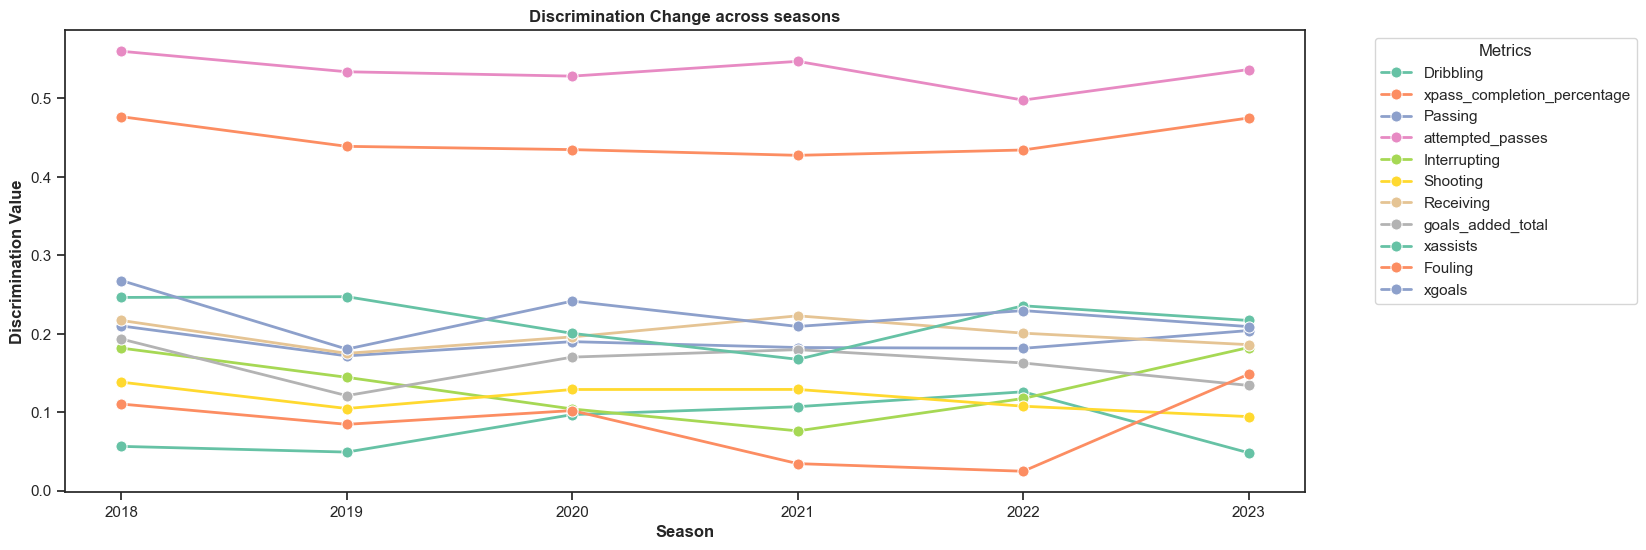

In [38]:
## Lineplot
lineplot_df = final_df.drop('stability', axis = 1).reset_index().melt( id_vars='index', var_name='season', value_name='discrimination')
lineplot_df

# Set a professional style
sns.set(style="ticks")

# Define a custom color palette
custom_palette = sns.color_palette("Set2", n_colors=lineplot_df['index'].nunique())

plt.figure(figsize=(16, 6))
sns.lineplot(x='season',
             y='discrimination',
             hue='index',
             data=lineplot_df,
             marker='o',
             palette=custom_palette,
            linewidth=2,
             markersize=8)

plt.title('Discrimination Change across seasons', fontweight = 'bold')
plt.xlabel('Season', fontweight = 'bold')
plt.ylabel('Discrimination Value', fontweight = 'bold')
# Move the legend outside
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')

## Write output
folder = 'results'
if not os.path.exists(folder):
    os.mkdir(folder)
export_path = folder + '/' + 'lineplot' + '.png'
plt.savefig(export_path, bbox_inches='tight')